In [1]:
import os
import sys

import numpy as np
import itertools as it

sys.path.append('../3_analyze')
from scores import ScoreContainer
from containers import LigandManager
from statistics import Statistics
from utils import stats_hist, plot_docking

In [2]:
import matplotlib
from matplotlib import pyplot as plt

get_ipython().magic(u'matplotlib inline')

In [3]:
data_dir = '/scratch/PI/rondror/jbelk/method/data'
out_dir = 'scores/scores4'

In [4]:
class Benchmark:
    def __init__(self, data_dir, out_dir):
        self.out_dir = out_dir
        self.datasets = [d for d in sorted(os.listdir(data_dir)) if d[0] != '.' and d[-3:] != 'old']
        self.all_lm = {p:LigandManager(p) for p in self.datasets}
        self.sc = self.init_results(data_dir, out_dir)
        
    def init_results(self, data_dir, out_dir):
        sc = {}
        for i,p in enumerate(self.datasets):
            #print 'loading',i,p
            root = '{}/{}/{}'.format(data_dir, p, out_dir)
            sc[p] = ScoreContainer(root, p, self.all_lm[p].st)
            sc[p].load_results()
        return sc
        
    def plot_dataset(self, d):
        queries = sorted(self.sc[d].results.keys())
        us_rmsds = [self.sc[d].get_rmsd(q,q) for q in queries]
        glide_rmsds = [self.sc[d].get_rmsd(q,q,glide=True) for q in queries]
        plot_rmsds(us_rmsds, glide_rmsds, queries, t1=self.out_dir, t2='Physics Method')
        
    def plot_summary(self, other=None):
        us_ave = []
        glide_ave = [] 
        for d in self.datasets:
            queries = sorted(self.sc[d].results.keys())
            us_rmsds = [self.sc[d].get_rmsd(q,q) for q in queries]
            if other is None:
                glide_rmsds = [self.sc[d].get_rmsd(q,q,glide=True) for q in queries]
                t2 = 'Physics Method'
            else:
                glide_rmsds = [other.sc[d].get_rmsd(q,q) for q in queries]
                t2 = other.out_dir
            if len(us_rmsds) == 0: print d
            us_ave.append(np.mean(us_rmsds))
            glide_ave.append(np.mean(glide_rmsds))

        plot_rmsds(us_ave, glide_ave, self.datasets, t1=self.out_dir, t2=t2)
        
    def show_docking(self, d):
        n_list = [1,5,25,100,300]
        p = self.sc[d].predict_data.proteins[d]
        all_rmsds = [ [] for n in n_list ]

        rmsds = p.docking[self.all_lm[d].st].glide_perf(n_list=n_list, ligands=self.all_lm[d].pdb)
        for i, n in enumerate(n_list):
            all_rmsds[i].extend(rmsds[i])

        plot_docking(all_rmsds, ['top-{}'.format(n) for n in n_list], '{}, {}'.format(d, self.all_lm[d].st))

In [5]:
def plot_rmsds(rmsds_us, rmsds_glide, legend, t1, t2):
    max_rmsd = max(rmsds_us + rmsds_glide)
    plt.figure(figsize=(6,6))
    plt.plot([0,max_rmsd],[0,max_rmsd],'--k')
    plt.plot([2,2],[0,max_rmsd],'--k')
    plt.plot([0,max_rmsd],[2,2],'--k')

    marker = it.cycle(('.','o','*','s','d','p','v','^'))
    for i in range(len(rmsds_us)):
        plt.plot(rmsds_us[i], rmsds_glide[i], marker=marker.next(), markersize=10, label=legend[i])

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=3, fontsize=14)

    plt.xlabel(t1, size=20)
    plt.ylabel(t2, size=20)
    plt.title('Error [RMSD, $\AA$]', size=20)
    plt.axis([0,max_rmsd+1,0,max_rmsd+1])
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

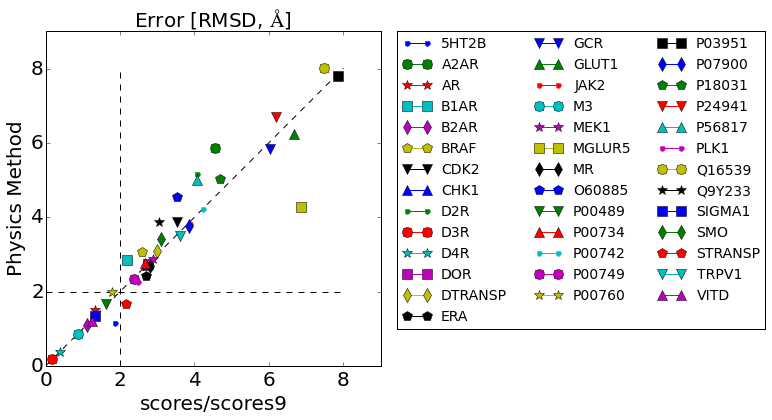

In [6]:
bench9 = Benchmark(data_dir, 'scores/scores9')
bench9.plot_summary()

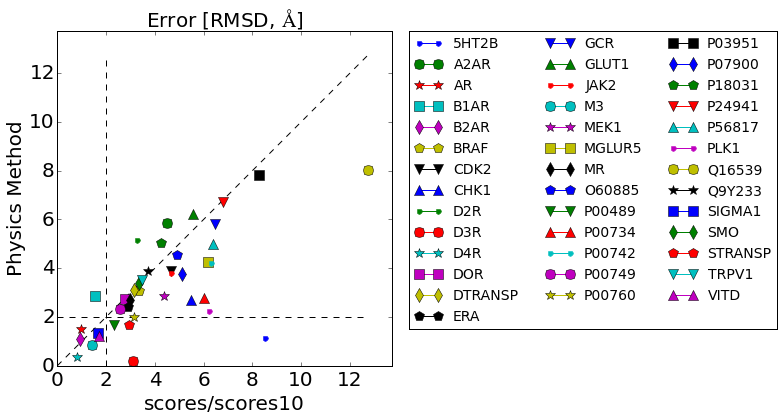

In [7]:
bench10 = Benchmark(data_dir, 'scores/scores10')
bench10.plot_summary()

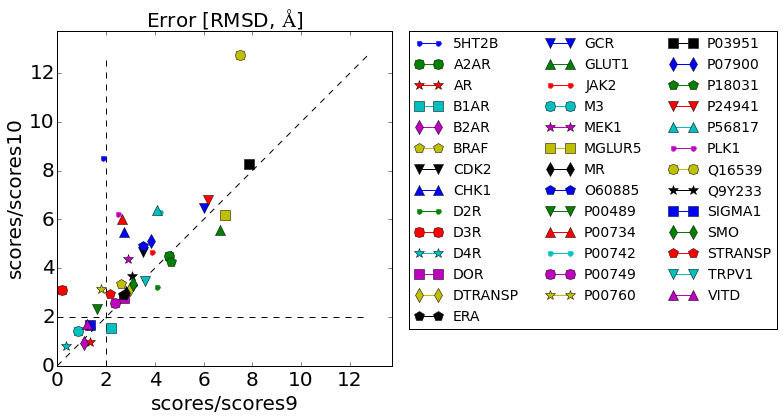

In [8]:
bench9.plot_summary(bench10)
#bench5.plot_summary(bench7)
#bench6.plot_summary(bench8)
#bench8.plot_summary(bench9)

In [ ]:
examine = 'D2R'
bench9.plot_dataset(examine)
bench9.show_docking(examine)

In [ ]:
bench = bench9

In [ ]:
for k in bench.sc[examine].stats.k_list:
    print k
    allp = -1
    decoy = 0
    native = 1
    stats_hist(bench.sc[examine].stats.dist[native][k], bench.sc[examine].stats.dist[allp][k])

In [ ]:
queries = sorted(bench.sc[examine].results.keys())
for q in queries:
    usr = bench.sc[examine].get_rmsd(q,q)
    gr = bench.sc[examine].get_rmsd(q,q,glide=True)
    #if not (usr > 2 and gr <= 2): continue
    print q
    print 'us:', usr
    print 'glide:', gr
    bench.sc[examine].show_fps(q,w={2:1,3:1,1:1,6:0})#,11:0.005})#11:0.005})
    for k in bench.sc[examine].stats.k_list:
        bench.sc[examine].show_feature(q, k, show_prob=True, show_x=True, size=2)
    #break

In [ ]:
#for q in queries:
bench.sc[examine].export_poses('4U16_lig')
#sc.export_poses(details)